In this notebook we perform parameter efficient fine-tuning (LoRA) of RoBERTa model. To find best hyperparameters we did grid search.

# PREREQUISITES:

In [5]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TrainerCallback
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from huggingface_hub import login
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

In [ ]:
login()

In [3]:
current_directory = os.getcwd() # get current directory
file_path = os.path.join(current_directory, '..', '..', 'data', 'processed', 'clean_data.csv') # navigate to folder with preprocessed data
data = pd.read_csv(file_path)

In [ ]:
print(data.head(5))

# Data splitting

In [5]:
X = data['heading_text'].values
y = data['bias_rating'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize data

In [7]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base') # load tokenizer

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [8]:
class NewsDataset(torch.utils.data.Dataset):
    """
    We need this class to manage and load
    encoded inputs and corresponding labels into a format compatible
    with PyTorch's DataLoader for model training and evaluation :)
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)


# Grid search for RoBERTa with LoRA

In [2]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# define ranges for hyperparameters
param_grid = {
    'learning_rate': [5e-5, 3e-5, 2e-5],
    'batch_size': [8, 16],
    'lora_alpha': [16, 32],
    'r': [8, 16],
    'lora_dropout': [0.1, 0.2]
}

In [ ]:
# If available, set the device to 'cuda' (GPU), otherwise set it to 'cpu'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

all_results = []

# Grid search over all parameter combinations
for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")

    # Load the model and apply LoRA configuration
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=params['r'],
        lora_alpha=params['lora_alpha'],
        lora_dropout=params['lora_dropout']
    )
    model_with_lora = get_peft_model(model, lora_config).to(device)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_lr_{params["learning_rate"]}_bs_{params["batch_size"]}_alpha_{params["lora_alpha"]}_r_{params["r"]}_dropout_{params["lora_dropout"]}',
        num_train_epochs=3,
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],
        learning_rate=params["learning_rate"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f'./logs_lr_{params["learning_rate"]}_bs_{params["batch_size"]}_alpha_{params["lora_alpha"]}_r_{params["r"]}_dropout_{params["lora_dropout"]}',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True
    )

    # Trainer setup
    trainer = Trainer(
        model=model_with_lora,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    # Evaluate and record results
    metrics = trainer.evaluate(eval_dataset=test_dataset)
    metrics.update(params)
    all_results.append(metrics)

best_result = max(all_results, key=lambda x: x['eval_accuracy']) # find the best result
print(f"Best Hyperparameters: {best_result}")

# Train model with best hyperparameters

In [ ]:
# define model with best found hyperparameters
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16,                
    lora_alpha=32,  
    lora_dropout=0.1
)

model_with_lora = get_peft_model(model, lora_config) # add LoRA to the model

In [4]:
model_with_lora.print_trainable_parameters() # see statistics of how many parameters will be trainined

trainable params: 1,182,723 || all params: 125,830,662 || trainable%: 0.9399


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_with_lora.to(device)

In [ ]:
# a callback class to log metrics after each epoch and save them to a CSV file
class LogMetricsCallback(TrainerCallback):
    def __init__(self, log_dir, csv_filename="roberta_lora.csv"):
        super().__init__()
        self.log_dir = log_dir
        self.csv_filepath = os.path.join(log_dir, csv_filename)
        os.makedirs(log_dir, exist_ok=True)
        
        # Initialize CSV file with headers if it doesn't exist
        if not os.path.exists(self.csv_filepath):
            pd.DataFrame(columns=["epoch", "accuracy", "precision", "recall", "f1"]).to_csv(self.csv_filepath, index=False)

    def on_epoch_end(self, args, state, control, **kwargs):
        metrics = state.log_history[-1]  # last entry should be the current epoch
        epoch = metrics.get("epoch")   # current epoch number
        accuracy = metrics.get("eval_accuracy")
        precision = metrics.get("eval_precision")
        recall = metrics.get("eval_recall")
        f1 = metrics.get("eval_f1")
        
        # add to CSV
        pd.DataFrame([{
            "epoch": epoch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }]).to_csv(self.csv_filepath, mode='a', header=False, index=False)
        
        print(f"Metrics for epoch {epoch} saved to {self.csv_filepath}")


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results_lora',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_lora',
    logging_steps=10,
    learning_rate=5e-5,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False  # lower eval_loss is better
)

log_dir = os.path.join(os.getcwd(), '..', '..', 'results')

trainer = Trainer(
    model=model_with_lora,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
    LogMetricsCallback(log_dir=log_dir),             
    EarlyStoppingCallback(early_stopping_patience=0) 
]
)

trainer.train()

# Evaluate model

In [ ]:
metrics = trainer.evaluate()
print(f"Test Accuracy: {metrics['eval_accuracy']}")

# Train and Test losses

   Epoch  Training Loss  Validation Loss  Accuracy  Precision    Recall  \
0      1         1.0084         0.957421  0.540124   0.592624  0.540124   
1      2         0.8863         0.911781  0.567717   0.568195  0.567717   
2      3         0.8436         0.901521  0.583812   0.586048  0.583812   

         F1  
0  0.477880  
1  0.538008  
2  0.565171  


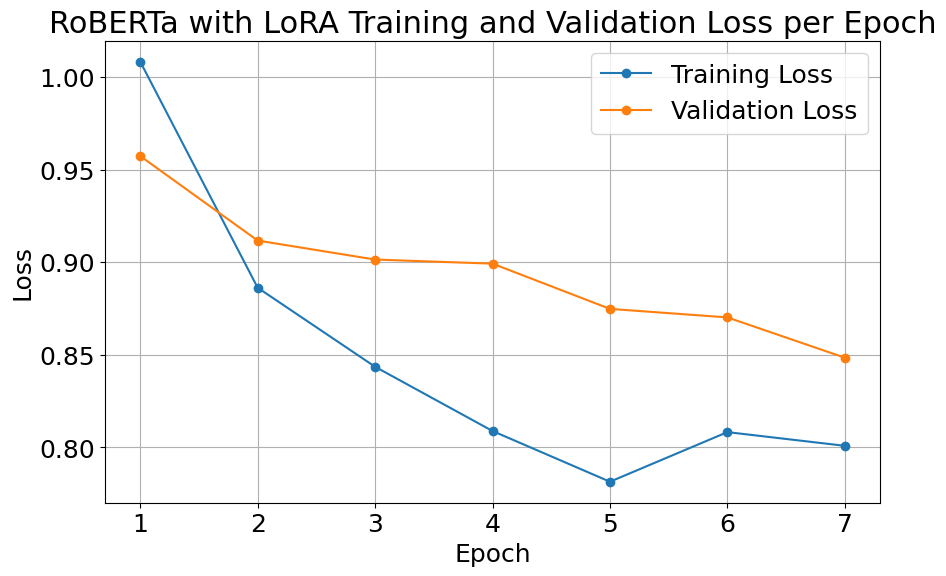

In [12]:
file_path = os.path.join(current_directory, '..', '..', 'results', 'roberta_lora.csv') # navigate to folder with results
data_to_plot = pd.read_csv(file_path)
print(data_to_plot.head(3))

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot['Epoch'], data_to_plot['Training Loss'], label='Training Loss', marker='o')
plt.plot(data_to_plot['Epoch'], data_to_plot['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("RoBERTa with LoRA Training and Validation Loss per Epoch", fontsize=22)

# Set legend font size
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
plt.show()